In [1]:
# Install dependencies (uncomment to run)
!pip install torch torchvision torchaudio tqdm matplotlib seaborn scikit-learn pillow

In [2]:
# Imports
import os
import random
import datetime
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from torchvision.models import ResNet50_Weights
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from PIL import Image

from sklearn.metrics import confusion_matrix, classification_report

In [3]:
# Configuration
image_size    = 200
batch_size    = 8     # typically smaller for detection models
num_epochs    = 20
learning_rate = 1e-4
patience      = 5     # early stopping patience

train_dir = 'dataset/Training'
test_dir  = 'dataset/Testing'
labels    = ['glioma', 'meningioma', 'notumor', 'pituitary']

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [4]:
# Dataset for Faster R‑CNN: one box = entire image
class BrainTumorDetectionDataset(Dataset):
    def __init__(self, root_dir, labels, transform=None):
        self.samples    = []
        self.labels_map = {lbl: i for i,lbl in enumerate(labels)}
        self.transform  = transform

        for lbl in labels:
            dir_path = os.path.join(root_dir, lbl)
            for fname in os.listdir(dir_path):
                if fname.lower().endswith(('.png','.jpg','jpeg','.bmp')):
                    self.samples.append((os.path.join(dir_path, fname),
                                         self.labels_map[lbl]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, lbl = self.samples[idx]
        img = Image.open(path).convert('RGB')
        w, h = img.size

        # full-image box
        boxes  = torch.tensor([[0, 0, w, h]], dtype=torch.float32)
        labels = torch.tensor([lbl + 1], dtype=torch.int64)
        target = {'boxes': boxes, 'labels': labels}

        if self.transform:
            img = self.transform(img)

        return img, target

# Transforms (for detection models we pass raw [0,1] Tensors)
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
])

# Prepare train/val split
full_ds   = BrainTumorDetectionDataset(train_dir, labels, transform=transform)
train_n   = int(0.75 * len(full_ds))
val_n     = len(full_ds) - train_n
train_ds, val_ds = random_split(full_ds, [train_n, val_n], generator=torch.Generator().manual_seed(42))

test_ds = BrainTumorDetectionDataset(test_dir, labels, transform=transform)

def collate_fn(batch):
    return tuple(zip(*batch))

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  collate_fn=collate_fn)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

In [5]:
# Model Definition: Faster R‑CNN with a ResNet50 backbone
model = fasterrcnn_resnet50_fpn(
    weights=None,
    weights_backbone=ResNet50_Weights.IMAGENET1K_V1,
    num_classes=len(labels) + 1    # +1 for background
)
model = model.to(device)

# Optimizer & LR Scheduler
params    = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       mode='min',
                                                       factor=0.3,
                                                       patience=5)

# Training Loop with Early Stopping
best_val_loss    = float('inf')
no_improve_epochs = 0

train_losses = []
val_losses   = []
val_accs     = []

for epoch in range(num_epochs):
    # — Training —
    model.train()
    running_loss = 0.0

    for images, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
        imgs    = [img.to(device) for img in images]
        targs   = [{k: v.to(device) for k,v in t.items()} for t in targets]

        loss_dict = model(imgs, targs)
        loss      = sum(loss_dict.values())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_train_loss = running_loss / len(train_loader)
    train_losses.append(epoch_train_loss)

    # — Validation —
    model.eval()
    val_loss   = 0.0
    all_preds  = []
    all_labels = []

    with torch.no_grad():
        for images, targets in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]"):
            imgs  = [img.to(device) for img in images]
            targs = [{k: v.to(device) for k,v in t.items()} for t in targets]

            # --- compute losses in train mode ---
            model.train()
            loss_dict = model(imgs, targs)
            val_loss += sum(loss_dict.values()).item()

            # --- switch back for inference/predictions ---
            model.eval()

            # run inference for accuracy
            outputs = model(imgs)
            for out, tgt in zip(outputs, targets):
                # pick highest-score box
                if len(out['labels']) > 0:
                    pred_lbl = out['labels'][0].cpu().item() - 1
                else:
                    pred_lbl = -1
                true_lbl = tgt['labels'][0].item() - 1

                all_preds.append(pred_lbl)
                all_labels.append(true_lbl)

    epoch_val_loss = val_loss / len(val_loader)
    val_losses.append(epoch_val_loss)

    # Classification accuracy on val
    val_acc = np.mean([p == t for p,t in zip(all_preds, all_labels)])
    val_accs.append(val_acc)

    # LR scheduler step
    scheduler.step(epoch_val_loss)

    # Early stopping
    if epoch_val_loss < best_val_loss - 1e-3:
        best_val_loss    = epoch_val_loss
        no_improve_epochs = 0
        torch.save(model.state_dict(), 'best_fasterrcnn.pth')
    else:
        no_improve_epochs += 1
        if no_improve_epochs >= patience:
            print(f"\nEarly stopping at epoch {epoch+1}")
            break

    print(f"\nEpoch {epoch+1} — Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f} | Val Acc: {val_acc:.4f}\n")

Epoch 1/20 [Val]: 100%|██████████| 179/179 [00:53<00:00,  3.35it/s]



Epoch 1 — Train Loss: 0.1820 | Val Loss: 0.1322 | Val Acc: 0.3375



Epoch 2/20 [Val]: 100%|██████████| 179/179 [00:49<00:00,  3.64it/s]



Epoch 2 — Train Loss: 0.1111 | Val Loss: 0.0647 | Val Acc: 0.2563



Epoch 3/20 [Val]: 100%|██████████| 179/179 [00:49<00:00,  3.65it/s]



Epoch 3 — Train Loss: 0.0824 | Val Loss: 0.0625 | Val Acc: 0.2409



Epoch 4/20 [Val]: 100%|██████████| 179/179 [00:49<00:00,  3.63it/s]



Epoch 4 — Train Loss: 0.0720 | Val Loss: 0.0802 | Val Acc: 0.2003



Epoch 5/20 [Val]: 100%|██████████| 179/179 [00:48<00:00,  3.66it/s]



Epoch 5 — Train Loss: 0.0603 | Val Loss: 0.0653 | Val Acc: 0.2451



Epoch 6/20 [Val]: 100%|██████████| 179/179 [00:46<00:00,  3.86it/s]



Epoch 6 — Train Loss: 0.0505 | Val Loss: 0.0441 | Val Acc: 0.2535



Epoch 7/20 [Val]: 100%|██████████| 179/179 [00:48<00:00,  3.66it/s]



Epoch 7 — Train Loss: 0.0495 | Val Loss: 0.0801 | Val Acc: 0.2017



Epoch 8/20 [Val]: 100%|██████████| 179/179 [00:45<00:00,  3.90it/s]



Epoch 8 — Train Loss: 0.0436 | Val Loss: 0.0393 | Val Acc: 0.2346



Epoch 9/20 [Val]: 100%|██████████| 179/179 [00:47<00:00,  3.75it/s]



Epoch 9 — Train Loss: 0.0402 | Val Loss: 0.0369 | Val Acc: 0.2157



Epoch 10/20 [Val]: 100%|██████████| 179/179 [00:48<00:00,  3.71it/s]



Epoch 10 — Train Loss: 0.0350 | Val Loss: 0.0579 | Val Acc: 0.2150



Epoch 11/20 [Val]: 100%|██████████| 179/179 [00:51<00:00,  3.45it/s]



Epoch 11 — Train Loss: 0.0342 | Val Loss: 0.0401 | Val Acc: 0.2157



Epoch 12/20 [Val]: 100%|██████████| 179/179 [00:53<00:00,  3.37it/s]



Epoch 12 — Train Loss: 0.0385 | Val Loss: 0.0422 | Val Acc: 0.3116



Epoch 13/20 [Val]: 100%|██████████| 179/179 [00:51<00:00,  3.46it/s]



Epoch 13 — Train Loss: 0.0297 | Val Loss: 0.0330 | Val Acc: 0.2227



Epoch 14/20 [Val]: 100%|██████████| 179/179 [00:50<00:00,  3.53it/s]



Epoch 14 — Train Loss: 0.0260 | Val Loss: 0.0297 | Val Acc: 0.2171



Epoch 15/20 [Val]: 100%|██████████| 179/179 [00:50<00:00,  3.56it/s]



Epoch 15 — Train Loss: 0.0274 | Val Loss: 0.0412 | Val Acc: 0.1807



Epoch 16/20 [Val]: 100%|██████████| 179/179 [00:49<00:00,  3.58it/s]



Epoch 16 — Train Loss: 0.0240 | Val Loss: 0.0365 | Val Acc: 0.2542



Epoch 17/20 [Val]: 100%|██████████| 179/179 [00:47<00:00,  3.74it/s]



Epoch 17 — Train Loss: 0.0234 | Val Loss: 0.0262 | Val Acc: 0.2136



Epoch 18/20 [Val]: 100%|██████████| 179/179 [00:48<00:00,  3.70it/s]



Epoch 18 — Train Loss: 0.0214 | Val Loss: 0.0245 | Val Acc: 0.2178



Epoch 19/20 [Val]: 100%|██████████| 179/179 [00:47<00:00,  3.80it/s]



Epoch 19 — Train Loss: 0.0204 | Val Loss: 0.0267 | Val Acc: 0.2115



Epoch 20/20 [Val]: 100%|██████████| 179/179 [00:46<00:00,  3.86it/s]


Epoch 20 — Train Loss: 0.0215 | Val Loss: 0.0382 | Val Acc: 0.2283



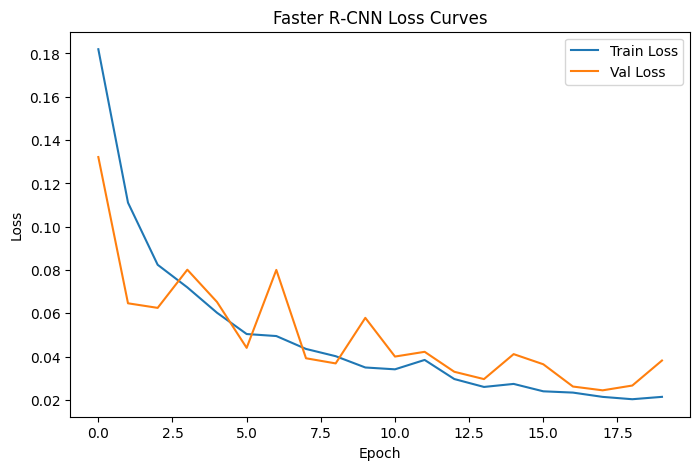

In [6]:
# Plot Loss Curves
plt.figure(figsize=(8,5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses,   label='Val Loss')
plt.title('Faster R‑CNN Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

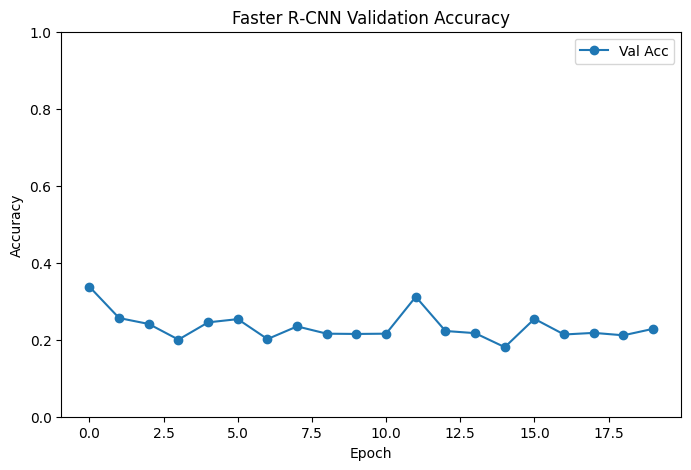

In [7]:
# Plot Validation Accuracy Curve
plt.figure(figsize=(8,5))
plt.plot(val_accs, marker='o', label='Val Acc')
plt.title('Faster R‑CNN Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.legend()
plt.show()

Testing: 100%|██████████| 164/164 [00:26<00:00,  6.11it/s]


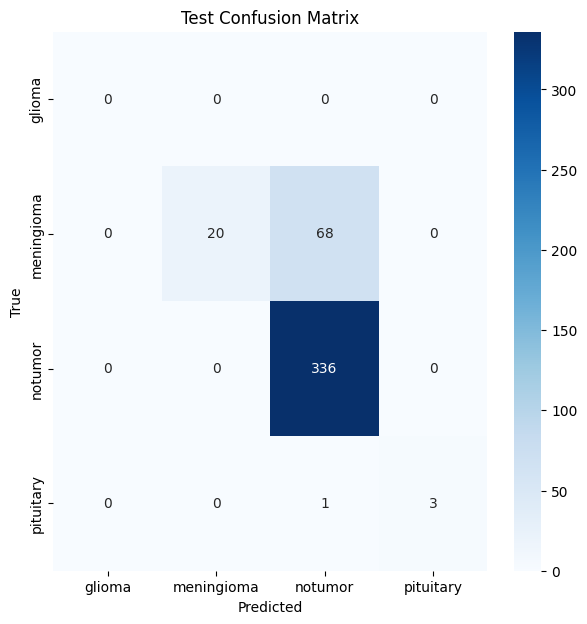

ValueError: Number of classes, 5, does not match size of target_names, 4. Try specifying the labels parameter

In [8]:
# — Final Evaluation on Test Set —
model.load_state_dict(torch.load('best_fasterrcnn.pth'))
model.eval()

test_preds  = []
test_labels = []

with torch.no_grad():
    for images, targets in tqdm(test_loader, desc="Testing"):
        imgs = [img.to(device) for img in images]
        outputs = model(imgs)

        for out, tgt in zip(outputs, targets):
            if len(out['labels']) > 0:
                pred_lbl = out['labels'][0].cpu().item() - 1
            else:
                pred_lbl = -1
            true_lbl = tgt['labels'][0].item() - 1

            test_preds.append(pred_lbl)
            test_labels.append(true_lbl)

# Confusion Matrix & Classification Report
cm = confusion_matrix(test_labels, test_preds, labels=list(range(len(labels))))
plt.figure(figsize=(7,7))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=labels, yticklabels=labels,
            cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Test Confusion Matrix')
plt.show()

print(classification_report(test_labels, test_preds, target_names=labels))